In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [2]:
import_path = "/Users/michalmacbookpro/Downloads/titanic/"
train = pd.read_csv(import_path + "train.csv",index_col="PassengerId")
test = pd.read_csv(import_path + "test.csv",index_col="PassengerId")
submision = pd.read_csv(import_path + "gender_submission.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
train[["man","woman"]] = pd.get_dummies(train["Sex"])
train[["1","2","3"]] = pd.get_dummies(train["Pclass"])
train[["c","q","s"]] = pd.get_dummies(train["Embarked"])

def cabinizer(df):
    df["Cabin_L"] = df["Cabin"].str.extract(r"(^\D{0,1})")
    df["Cabin_L"].fillna("U",inplace=True)
    df["Cabin_L"] = df["Cabin_L"].map({"A":"ABC","B":"ABC","C":"ABC","D":"DE","E":"DE","F":"FG","G":"FG","T":"ABC","U":"U"})
    return df

def familiazer(df):
    df["Family"] = df["SibSp"] + df["Parch"]
    df["Family"] = df["Family"]
    return df


def aloniazer(df):
    df["Alone"] = 0
    df.loc[df["Family"]==0,"Alone"] = 1
    return df

cabinizer(train)
familiazer(train)
aloniazer(train)

train[["ABC","DE","FG","U"]] = pd.get_dummies(train["Cabin_L"])

to_drop = ["Pclass","Name","Sex","SibSp","Parch","Ticket","Cabin","Embarked","Cabin_L","Family","Age","2","q","FG"]
train.drop(to_drop,inplace=True,axis=1)

mean_fare = np.mean(train["Fare"])
std_fare = np.std(train["Fare"])

train["Fare"] = (train["Fare"] - mean_fare)/std_fare
train.sample(15)

,Survived,Fare,man,woman,1,3,c,s,Alone,ABC,DE,U
PassengerId,,,,,,,,,,,,
30,0,-0.489442,0,1,0,1,0,1,1,0,0,1
884,0,-0.437007,0,1,0,0,0,1,1,0,0,1
313,0,-0.124920,1,0,0,0,0,1,0,0,0,1
852,0,-0.491874,0,1,0,1,0,1,1,0,0,1
477,0,-0.225593,0,1,0,0,0,1,0,0,0,1
1,0,-0.502445,0,1,0,1,0,1,0,0,0,1
686,0,0.188763,0,1,0,0,1,0,0,0,0,1
693,1,0.489104,0,1,0,1,0,1,1,0,0,1
138,0,0.420730,0,1,1,0,0,1,0,1,0,0


In [5]:
y = train["Survived"]
X = train.drop(["Survived"],axis=1)

<AxesSubplot:>

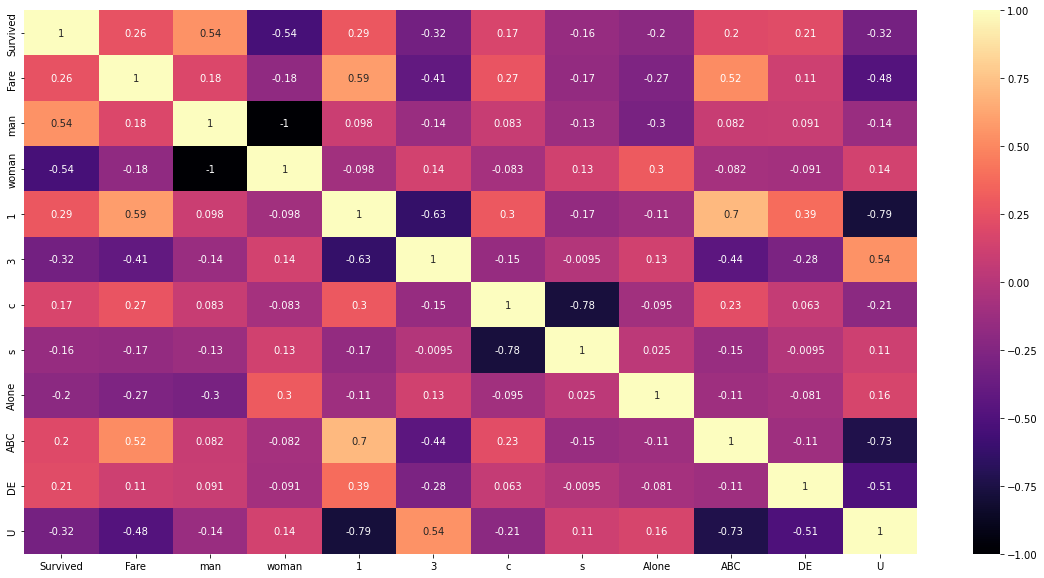

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(),annot=True,cmap="magma")

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05,random_state=42,stratify=y)

In [9]:
#X_train_t = torch.tensor(X_train.values, dtype=torch.float)
#X_test_t = torch.tensor(X_test.values, dtype=torch.float)
#y_train_t = torch.tensor(y_train.values, dtype=torch.float)
#y_test_t = torch.tensor(y_test.values, dtype=torch.float)

#print(f"X_train shape {X_train.shape} \nX_test shape {X_test.shape}")

In [10]:
X_train_t = torch.tensor(X.values, dtype=torch.float)
y_train_t = torch.tensor(y.values, dtype=torch.float)

In [11]:
input_shape = X.shape[1]
hiden_shape = 266 #input_shape*2

In [12]:
model = nn.Sequential(
    nn.Linear(input_shape,hiden_shape),
    nn.Dropout(p=0.1),
    nn.LeakyReLU(),
    nn.Linear(hiden_shape,10),
    nn.Dropout(p=0.1),
    nn.Linear(10,1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=11, out_features=266, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=266, out_features=10, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): Linear(in_features=10, out_features=1, bias=True)
  (6): Sigmoid()
)

In [13]:
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.019,weight_decay=1e-5)

In [14]:
log_e = 10
epochs = 9000

for epoch in range(epochs):
    pred = model(X_train_t)[:,0]
    loss = loss_fn(pred,y_train_t)
    loss.backward()
    optim.step()
    optim.zero_grad()
    if epoch % log_e ==0:
        print(epoch, loss)


0 tensor(0.6817, grad_fn=<BinaryCrossEntropyBackward0>)
10 tensor(0.4433, grad_fn=<BinaryCrossEntropyBackward0>)
20 tensor(0.4155, grad_fn=<BinaryCrossEntropyBackward0>)
30 tensor(0.4041, grad_fn=<BinaryCrossEntropyBackward0>)
40 tensor(0.3953, grad_fn=<BinaryCrossEntropyBackward0>)
50 tensor(0.3883, grad_fn=<BinaryCrossEntropyBackward0>)
60 tensor(0.3906, grad_fn=<BinaryCrossEntropyBackward0>)
70 tensor(0.3814, grad_fn=<BinaryCrossEntropyBackward0>)
80 tensor(0.3732, grad_fn=<BinaryCrossEntropyBackward0>)
90 tensor(0.3859, grad_fn=<BinaryCrossEntropyBackward0>)
100 tensor(0.3705, grad_fn=<BinaryCrossEntropyBackward0>)
110 tensor(0.3697, grad_fn=<BinaryCrossEntropyBackward0>)
120 tensor(0.3598, grad_fn=<BinaryCrossEntropyBackward0>)
130 tensor(0.3614, grad_fn=<BinaryCrossEntropyBackward0>)
140 tensor(0.3613, grad_fn=<BinaryCrossEntropyBackward0>)
150 tensor(0.3557, grad_fn=<BinaryCrossEntropyBackward0>)
160 tensor(0.3657, grad_fn=<BinaryCrossEntropyBackward0>)
170 tensor(0.3566, grad_f

#### 0.4531 Adam shalow NN
#### 0.3613 Adam 1 hiden NN lr=0.01
#### 0.2981 Adam 1 hiden NN lr=0.02, WD=1e-5
#### 0.2894 Adam 1 hiden NN lr=0.019, WD=1e-5

In [15]:
with torch.no_grad():
    y_pred = model(X_train_t)[:,0]
    #print(y_pred)
    print(accuracy_score(y_pred.int(),y_train_t))
#print(y_pred.int())


0.6711560044893379


In [16]:
test[["man","woman"]] = pd.get_dummies(test["Sex"])
test[["1","2","3"]] = pd.get_dummies(test["Pclass"])
test[["c","q","s"]] = pd.get_dummies(test["Embarked"])

def cabinizer(df):
    df["Cabin_L"] = df["Cabin"].str.extract(r"(^\D{0,1})")
    df["Cabin_L"].fillna("U",inplace=True)
    df["Cabin_L"] = df["Cabin_L"].map({"A":"ABC","B":"ABC","C":"ABC","D":"DE","E":"DE","F":"FG","G":"FG","T":"ABC","U":"U"})
    return df

def familiazer(df):
    df["Family"] = df["SibSp"] + df["Parch"]
    df["Family"] = df["Family"]
    return df


def aloniazer(df):
    df["Alone"] = 0
    df.loc[df["Family"]==0,"Alone"] = 1
    return df

cabinizer(test)
familiazer(test)
aloniazer(test)

test[["ABC","DE","FG","U"]] = pd.get_dummies(test["Cabin_L"])

to_drop = ["Pclass","Name","Sex","SibSp","Parch","Ticket","Cabin","Embarked","Cabin_L","Family","Age","2","q","FG"]
test.drop(to_drop,inplace=True,axis=1)

mean_fare = np.mean(test["Fare"])
std_fare = np.std(test["Fare"])

test["Fare"] = (test["Fare"] - mean_fare)/std_fare
test.sample(15)

,Fare,man,woman,1,3,c,s,Alone,ABC,DE,U
PassengerId,,,,,,,,,,,
1013,-0.499229,0,1,0,1,0,0,0,0,0,1
1301,-0.391332,1,0,0,1,0,1,0,0,0,1
1022,-0.493856,0,1,0,1,0,1,1,0,0,1
923,-0.073910,0,1,0,0,0,1,0,0,0,1
992,0.354841,1,0,1,0,1,0,0,1,0,0
912,0.425727,0,1,1,0,1,0,0,0,0,1
929,-0.482888,1,0,0,1,0,1,1,0,0,1
1173,-0.391332,0,1,0,1,0,1,0,0,0,1
932,-0.397749,0,1,0,1,1,0,0,0,0,1


In [17]:
test_t = torch.tensor(test.values, dtype=torch.float)

In [18]:
with torch.no_grad():
    submision["Survived"] = model(test_t)[:,0].int()
submision.to_csv('submission.csv', index = False)
submision["Survived"].value_counts()

 0             392
 1              25
-2147483648      1
Name: Survived, dtype: int64

In [19]:
np.unique(submision["Survived"])

array([-2147483648,           0,           1], dtype=int32)

In [20]:
submision[submision["Survived"]<0]

,PassengerId,Survived
152,1044,-2147483648
